In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [37]:
# Importing the dataset
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose([transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

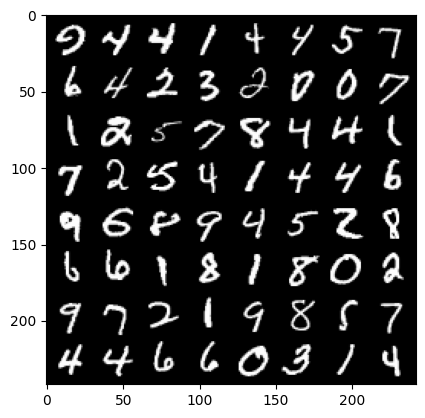

In [38]:
# Exploring the dataset

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [39]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 64
N_OUTPUTS = 10
N_EPHOCS = 10

In [40]:
# RNN Model
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.timestamp = 0
        
        # 設 batch_first=True → 輸入維度 (batch, seq_len, input_size)
        self.rnn = nn.RNN(self.n_inputs, self.n_neurons, batch_first=True, nonlinearity="relu") 
        self.out = nn.Linear(self.n_neurons, self.n_outputs)
        
        # 讓外部可以直接用 model.hidden_size
        self.hidden_size = n_neurons

    def init_hidden(self):
        """建立初始隱藏狀態 (num_layers=1, batch, hidden_size)"""
        device = next(self.parameters()).device
        dtype = next(self.parameters()).dtype
        return torch.zeros(1, self.batch_size, self.n_neurons, device=device, dtype=dtype)

    def forward(self, X):
        # X: (batch, seq_len, input_size)
        self.batch_size = X.size(0)  # 自動更新 batch_size
        h0 = self.init_hidden()      # (1, batch, hidden_size)
        self.time_step = X.size(1)
        rnn_out, h_n = self.rnn(X, h0)   # rnn_out: (batch, seq_len, hidden_size)
        last = rnn_out[:, -1, :]               # 取最後一個時間步 (batch, hidden_size)
        logits = self.out(last)                 # (batch, n_outputs)
        return logits

In [41]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0145, -0.1123, -0.0764, -0.0553, -0.0221,  0.0360, -0.0040,  0.0376,
          0.0552,  0.0998],
        [-0.0202, -0.0931, -0.0686, -0.0572, -0.0308,  0.0395,  0.0063,  0.0329,
          0.0566,  0.0941],
        [-0.0184, -0.1100, -0.0789, -0.0538, -0.0232,  0.0344, -0.0014,  0.0356,
          0.0547,  0.0976],
        [-0.0247, -0.1128, -0.0765, -0.0563, -0.0149,  0.0388,  0.0123,  0.0262,
          0.0580,  0.0964],
        [-0.0336, -0.1061, -0.0926, -0.0496, -0.0243,  0.0172,  0.0053,  0.0279,
          0.0562,  0.0934],
        [-0.0171, -0.1124, -0.0774, -0.0546, -0.0234,  0.0353, -0.0018,  0.0370,
          0.0558,  0.0993],
        [-0.0170, -0.1119, -0.0777, -0.0551, -0.0234,  0.0352, -0.0021,  0.0369,
          0.0553,  0.0985],
        [-0.0155, -0.1140, -0.0758, -0.0546, -0.0227,  0.0359, -0.0027,  0.0378,
          0.0562,  0.1020],
        [-0.0166, -0.1132, -0.0763, -0.0541, -0.0231,  0.0357, -0.0011,  0.0369,
          0.0552,  0.0998],
        [-0.0219, -

In [42]:
# Training
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.9023 | Train Accuracy: 70.06
Epoch:  1 | Loss: 0.5105 | Train Accuracy: 84.75
Epoch:  2 | Loss: 0.3847 | Train Accuracy: 88.66
Epoch:  3 | Loss: 0.3109 | Train Accuracy: 90.96
Epoch:  4 | Loss: 0.2558 | Train Accuracy: 92.58
Epoch:  5 | Loss: 0.2197 | Train Accuracy: 93.77
Epoch:  6 | Loss: 0.1935 | Train Accuracy: 94.45
Epoch:  7 | Loss: 0.1711 | Train Accuracy: 95.06
Epoch:  8 | Loss: 0.1573 | Train Accuracy: 95.37
Epoch:  9 | Loss: 0.1467 | Train Accuracy: 95.77


In [43]:
print(model.hidden_size)
print(model.time_step)

64
28


In [44]:
model_name = f'rnn_28_64_relu'
save_dir = os.path.join('./models/mnist_classifier/', model_name)
os.makedirs(save_dir, exist_ok=True)
            
torch.save(model.cpu().state_dict(), os.path.join(save_dir, 'rnn'))
model.to(device)
print(f"Model saved to {save_dir}/rnn")

Model saved to ./models/mnist_classifier/rnn_28_64_relu/rnn
